# Learning an emulator for the Lorenz equation

The Lorenz equations are a system of nonlinear ordinary differential equations
that exhibit chaotic behavior.

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= x y - \beta z
\end{aligned}
$$

Writing them as system of ODEs $\frac{du}{dt} = f(u)$ with $u \in \mathbb{R}^3$
we are interested in learning the discrete mapping from one time level $u^{[t]}$
to the next $u^{[t+1]}$ with a fixed time step size $\Delta t$. To do so, we
will create a dataset of sample trajectories from a RK4 solver applied to the
Lorenz equations. The emulator is going to be a simple Multi-Layer Perceptron
(MLP) trained to predict one step into the future starting at points sampled
across all trajectories and across time.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import equinox as eqx

In [2]:
import trainax as tx

/home/felix/Documents/phd/local_repos/trainax/trainax/_general_trainer.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Data Generation and Inspection

`Trainax` has a built-in helper to produce sample trajectories from the Lorenz
equations. `num_samples` here refers to the number of trajectories.

In [3]:
lorenz_data_trj = tx.sample_data.lorenz_rk4(num_samples=9, key=jax.random.PRNGKey(0))
# (num_trjs, num_steps, num_dofs=3)
lorenz_data_trj.shape

(9, 1000, 3)

Let's visualize one of the reference Lorenz trajectories in state space. It has
the typical butterfly shape.

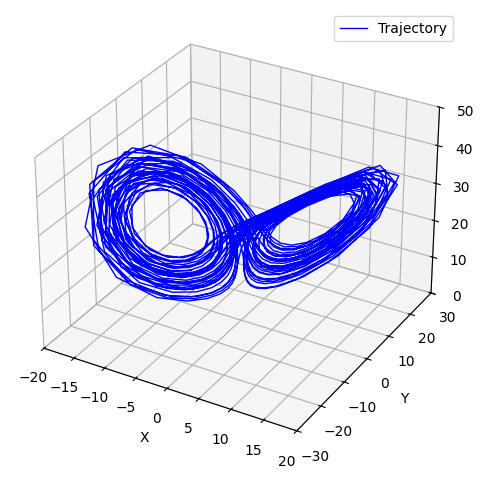

In [4]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

TRJ_INDEX = 0
ax.plot(
    lorenz_data_trj[TRJ_INDEX, :, 0],
    lorenz_data_trj[TRJ_INDEX, :, 1],
    lorenz_data_trj[TRJ_INDEX, :, 2],
    lw=1.0,
    color="blue",
    label="Trajectory",
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-20, 20)
ax.set_ylim(-30, 30)
ax.set_zlim(0, 50)
plt.legend()
plt.tight_layout()
plt.show()

Visualizing all 9 trajectories at once reveals that they are all quite similar
caused by being around the chaotic attractor the Lorenz equation is known for.

/tmp/ipykernel_31964/236270353.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


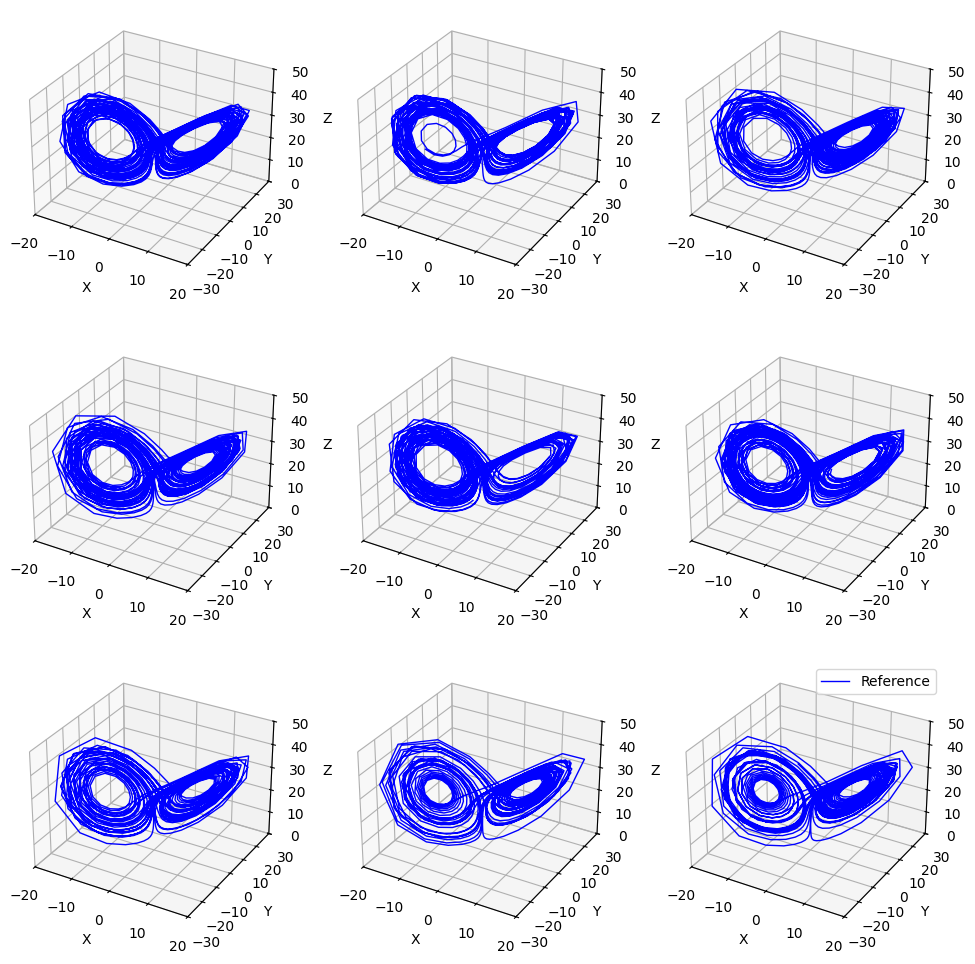

In [5]:
fig, axs = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(12, 12))

STEPS_TO_PLOT = -1
for i, ax in enumerate(axs.flat):
    ax.plot(
        lorenz_data_trj[i, :STEPS_TO_PLOT, 0],
        lorenz_data_trj[i, :STEPS_TO_PLOT, 1],
        lorenz_data_trj[i, :STEPS_TO_PLOT, 2],
        lw=1.0,
        color="blue",
        label="Reference",
    )
    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.legend()

Plotting the values of the three variables over time for all the 9 trajectories.

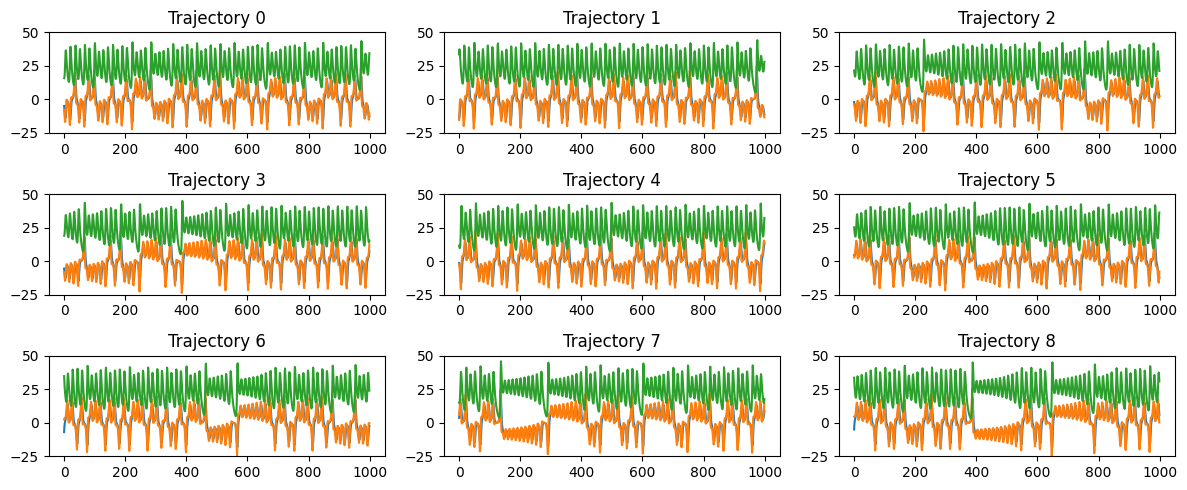

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(12, 5))

for i, ax in enumerate(axs.flat):
    ax.plot(lorenz_data_trj[i], label=["X", "Y", "Z"])
    ax.set_title(f"Trajectory {i}")
    ax.set_ylim(-25, 50)

plt.tight_layout()

A sanity check that the trajectories are free from diverged values.

In [7]:
# Check for the presence of NaNs
jnp.any(jnp.isnan(lorenz_data_trj))

Array(False, dtype=bool)

## Emulator Training

The emulator is a simple MLP with 60 hidden units and 6 hidden layers together
with the ReLU activation function.

In [8]:
emulator = eqx.nn.MLP(3, 3, 60, 6, jax.nn.relu, key=jax.random.PRNGKey(0))

The trainer object is the highest level interface to `Trainax`. It combines
sampling across the trajectories with a loss configuration (here one-step
supervised learning) and the iterative nature of network training.

Note the notion of `num_training_steps`. We do not specify the number of epochs
but work solely in terms of how often the network weights will be updated.
Internally, the trainer will determine the number of epochs necessary.

In [9]:
sup_1_trainer = tx.trainer.SupervisedTrainer(
    lorenz_data_trj,
    optimizer=optax.adam(3e-4),
    num_training_steps=20_000,
    batch_size=32,
    num_rollout_steps=1,  # one-step supervised training (would have been the default)
)

The trainer is now a callable object which takes an initial state of the
emulator (which comes from the initialization of the network) and a jax random
key to kickstart the stochastic minibatching. It then returns the trained
instance of the emulator (with the modified weights) as well as an array
containing the loss values over the training steps.

For the training a tqdm progress meter is spawned to visualize the progress.

In [10]:
sup_1_trained_emu, sup_1_loss_history = sup_1_trainer(emulator, jax.random.PRNGKey(42))

E: 00071, B: 00048: 100%|██████████| 20000/20000 [01:14<00:00, 267.60it/s]


The training loss sufficiently decreased over the training steps.

Text(0, 0.5, 'Train Loss')

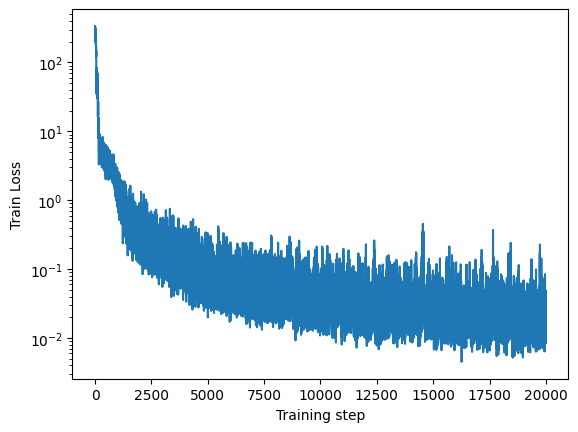

In [11]:
plt.semilogy(sup_1_loss_history)
plt.xlabel("Training step")
plt.ylabel("Train Loss")

## Evaluating the Emulator

We will evaluate the emulator on the same trajectories as it was trained. This
is not an issue because we will test for **temporal generalization**, i.e., for
how many steps it can correctly autoregressively predict into the future and if
it is able to reproduce certain properties of the Lorenz attractor.

The below rollout transformation is an efficient routine to autoregressively run
the emulator.

In [12]:
def rollout(stepper, n, *, include_init: bool = False):
    def scan_fn(u, _):
        u_next = stepper(u)
        return u_next, u_next

    def rollout_fn(u_0):
        _, trj = jax.lax.scan(scan_fn, u_0, None, length=n)

        if include_init:
            return jnp.concatenate([jnp.expand_dims(u_0, axis=0), trj], axis=0)

        return trj

    return rollout_fn

In [13]:
sup_1_emulator_trj = jax.vmap(
    rollout(sup_1_trained_emu, lorenz_data_trj.shape[1] - 1, include_init=True)
)(lorenz_data_trj[:, 0, :])
sup_1_emulator_trj.shape

(9, 1000, 3)

Let's visualize the first 20 steps of emulator and simulator next to each other.

They diverge over the steps which is expected due to the chaotic nature of the
Lorenz equations.

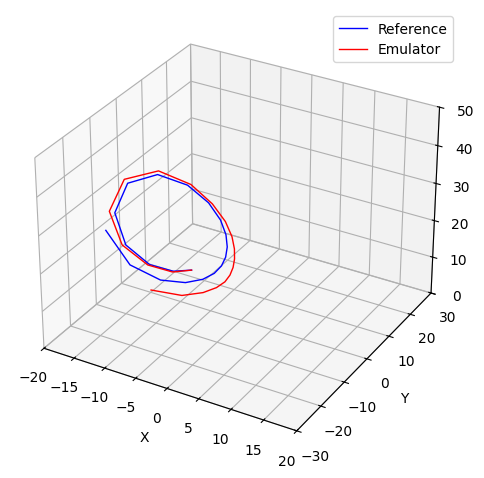

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

TRJ_INDEX = 0
STEPS_TO_PLOT = 20
ax.plot(
    lorenz_data_trj[TRJ_INDEX, :STEPS_TO_PLOT, 0],
    lorenz_data_trj[TRJ_INDEX, :STEPS_TO_PLOT, 1],
    lorenz_data_trj[TRJ_INDEX, :STEPS_TO_PLOT, 2],
    lw=1.0,
    color="blue",
    label="Reference",
)
ax.plot(
    sup_1_emulator_trj[TRJ_INDEX, :STEPS_TO_PLOT, 0],
    sup_1_emulator_trj[TRJ_INDEX, :STEPS_TO_PLOT, 1],
    sup_1_emulator_trj[TRJ_INDEX, :STEPS_TO_PLOT, 2],
    lw=1.0,
    color="red",
    label="Emulator",
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-20, 20)
ax.set_ylim(-30, 30)
ax.set_zlim(0, 50)
plt.legend()
plt.tight_layout()
plt.show()

This divergence is visible across all trajectories.

/tmp/ipykernel_31964/128260609.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


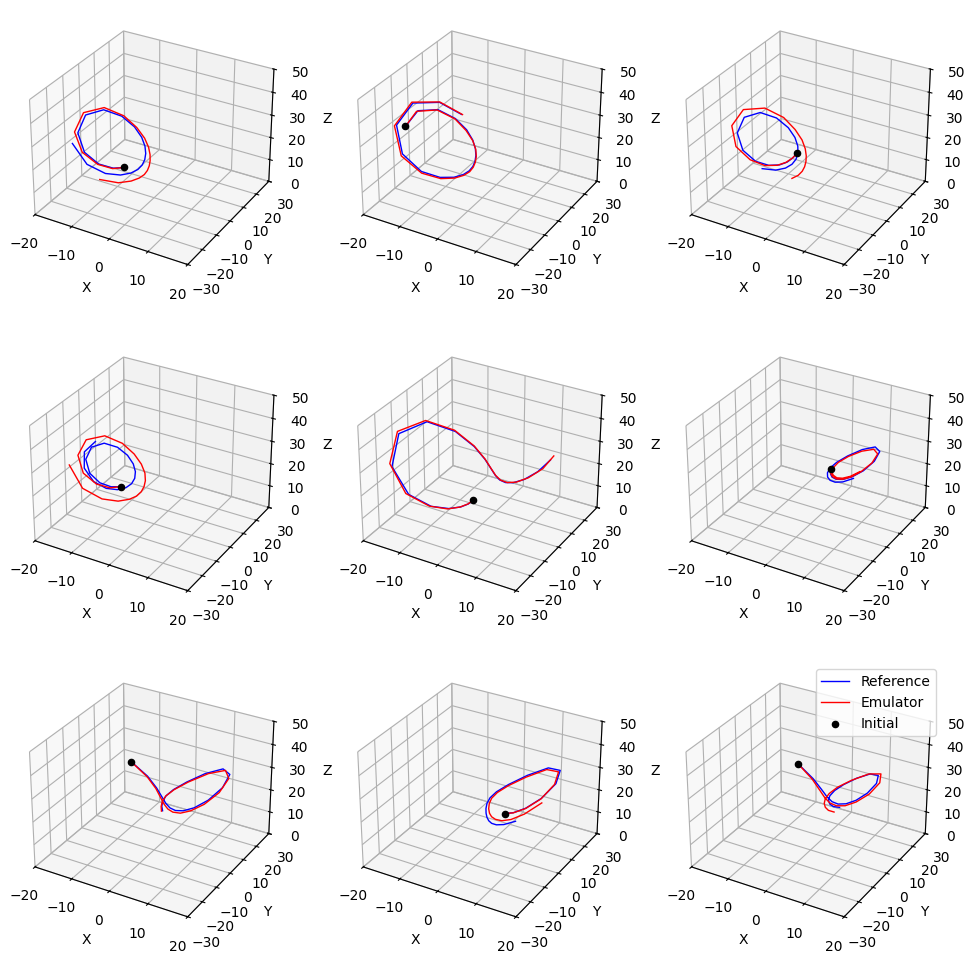

In [15]:
fig, axs = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(12, 12))

STEPS_TO_PLOT = 20
for i, ax in enumerate(axs.flat):
    ax.plot(
        lorenz_data_trj[i, :STEPS_TO_PLOT, 0],
        lorenz_data_trj[i, :STEPS_TO_PLOT, 1],
        lorenz_data_trj[i, :STEPS_TO_PLOT, 2],
        lw=1.0,
        color="blue",
        label="Reference",
    )
    ax.plot(
        sup_1_emulator_trj[i, :STEPS_TO_PLOT, 0],
        sup_1_emulator_trj[i, :STEPS_TO_PLOT, 1],
        sup_1_emulator_trj[i, :STEPS_TO_PLOT, 2],
        lw=1.0,
        color="red",
        label="Emulator",
    )
    ax.scatter(
        lorenz_data_trj[i, 0, 0],
        lorenz_data_trj[i, 0, 1],
        lorenz_data_trj[i, 0, 2],
        color="black",
        label="Initial",
    )
    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.legend()

Now let's look at a very long trajectory of 1000 steps produced by the emulator.
A good emulator would produce plots which are similar to the ones we saw by the
simulator earlier. However, it is clearly visible that the emulator is only
partially capable of reproducing the Lorenz attractor.

For some trajectories, the visual match is quite good. Some trajectories favor
one side of the attractor more than the other.

/tmp/ipykernel_31964/3262587441.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


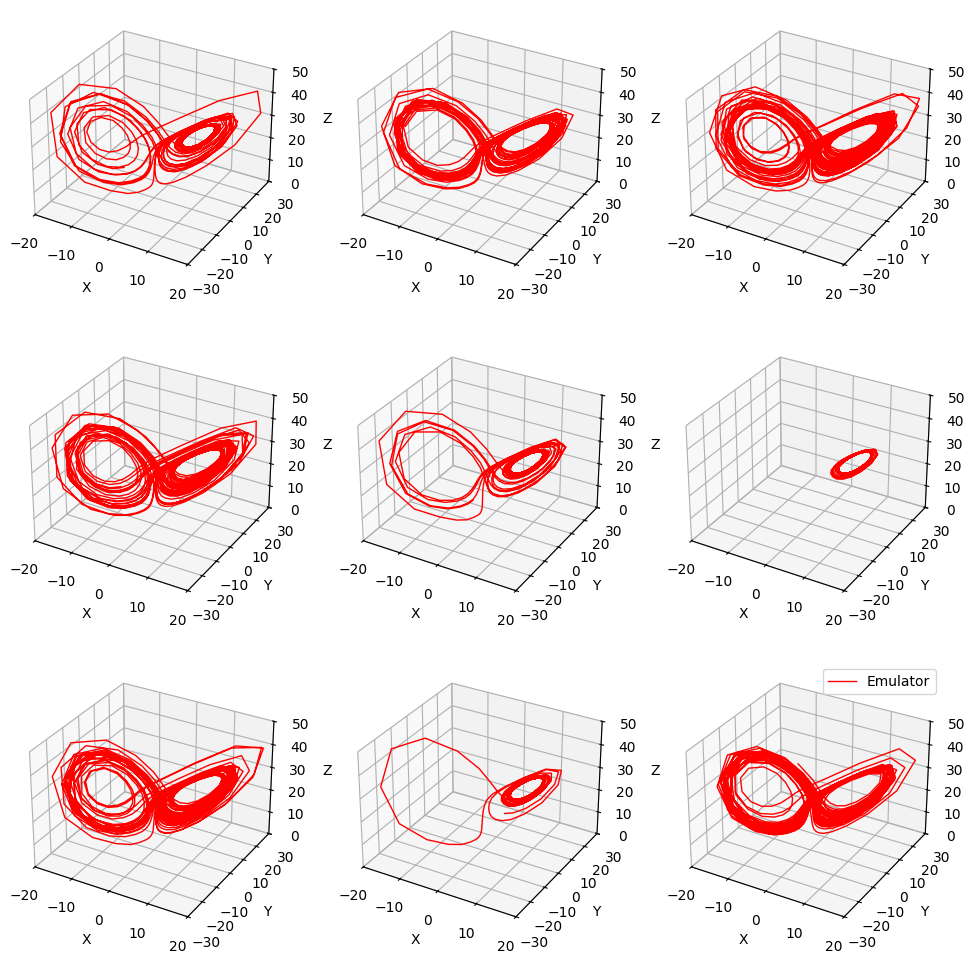

In [16]:
fig, axs = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(12, 12))

STEPS_TO_PLOT = -1
for i, ax in enumerate(axs.flat):
    ax.plot(
        sup_1_emulator_trj[i, :STEPS_TO_PLOT, 0],
        sup_1_emulator_trj[i, :STEPS_TO_PLOT, 1],
        sup_1_emulator_trj[i, :STEPS_TO_PLOT, 2],
        lw=1.0,
        color="red",
        label="Emulator",
    )
    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.legend()

This can also be seen in the temporal plots of all three variables. The
trajectories in which one side is favored are the ones in which the emulator
seems to enter a dead end after some time.

However, across all trajectories, the emulator seems to understand that the
green curve (corresponding to the z variable) is always positive and hence above
blue (x) and orange (y). It also understands that the x and y variables are
always very close.

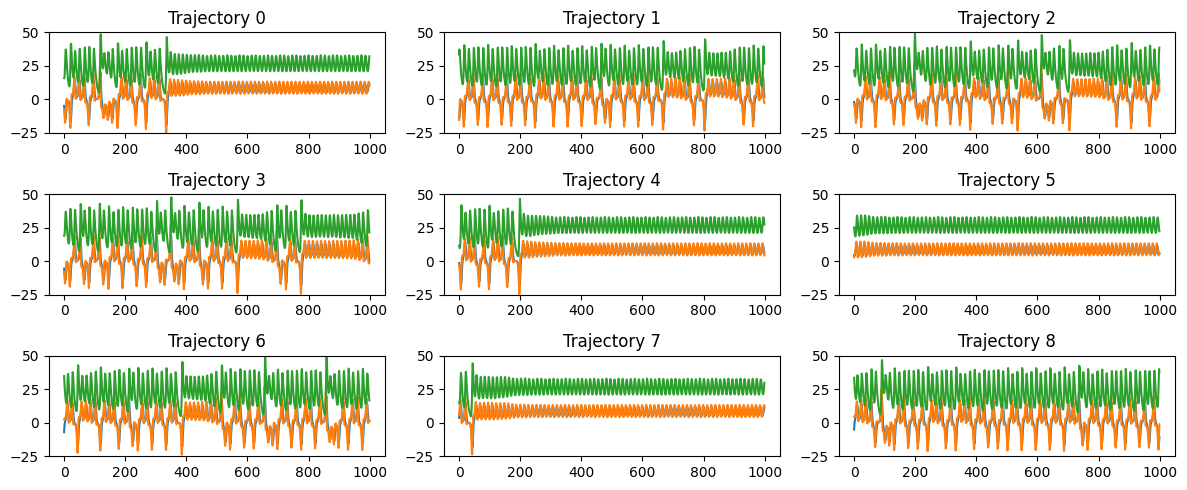

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(12, 5))

for i, ax in enumerate(axs.flat):
    ax.plot(sup_1_emulator_trj[i], label=["X", "Y", "Z"])
    ax.set_title(f"Trajectory {i}")
    ax.set_ylim(-25, 50)

plt.tight_layout()

For completion, let's also compute the error rollout across all trajectories.

In [18]:
nmse_loss = tx.loss.Normalized_MSELoss()

In [19]:
sup_1_error_trj = jax.vmap(nmse_loss, in_axes=1)(sup_1_emulator_trj, lorenz_data_trj)

As expected, there is a very strong error growth over time. Hence, we cannot
just judge the emulator's quality in this direct comparison against the
reference trajectories.

Still, it is able to mimic the RK4 simulator very closely for the first 10 steps
and the difference is still acceptable until 40 time steps.

Text(0, 0.5, 'Mean normalized MSE')

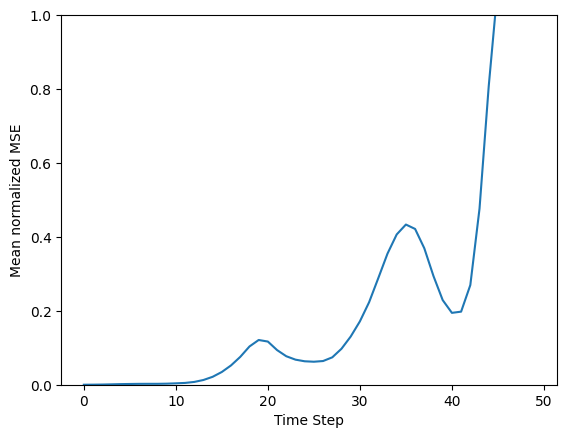

In [20]:
plt.plot(sup_1_error_trj[:50])
plt.ylim(0, 1)
plt.xlabel("Time Step")
plt.ylabel("Mean normalized MSE")